In [ ]:
! pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/fake-news-detection")

print("Path to dataset files:", path)

100%|██████████| 41.0M/41.0M [00:00<00:00, 242MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhavikjikadara/fake-news-detection/versions/1


In [ ]:
df_fake = pd.read_csv(path + "/fake.csv")
df_true = pd.read_csv(path + "/true.csv")

In [ ]:
df_true['target'] = ['True'] * len(df_true)
df_fake['target'] = ['Fake'] * len(df_fake)
data = pd.concat([df_true, df_fake]).sample(frac = 1).reset_index().drop(columns = ['index'])
print(data.shape)

(44898, 5)


In [ ]:
data['label'] = pd.get_dummies(data.target)['Fake']

In [ ]:
data.head()

,title,text,subject,date,target,label
0,Rohingya widows find safe haven in Bangladesh ...,COX S BAZAR (Reuters) - Dawn hues of pink and ...,worldnews,"December 7, 2017",True,False
1,"Mexico welcomes U.S. NAFTA objectives, eyes st...",MEXICO CITY (Reuters) - Mexico’s government on...,politicsNews,"July 18, 2017",True,False
2,Bundy Terrorists Dug Feces-Filled Trench On S...,Now that the Bundy terrorists have been arrest...,News,"February 17, 2016",Fake,True
3,JUST IN! SURPRISE GUEST Shows Up At Nationals ...,"Shortly after 7 a.m. on Wednesday, the police ...",politics,"Jun 15, 2017",Fake,True
4,Kim Jong Un And North Korean Media Enthusiast...,When your presidential candidate is supported ...,News,"May 31, 2016",Fake,True


In [ ]:
data['label'] = data['label'].astype(int)

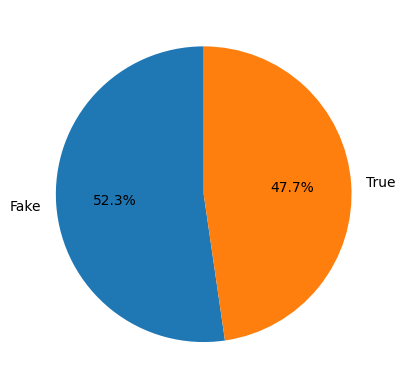

In [ ]:
label_size = [data['label'].sum(), len(data['label']) - data['label'].sum()]
plt.pie(label_size, labels = ['Fake', 'True'], autopct = '%1.1f%%', startangle = 90)
plt.show()

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['label'])

In [ ]:
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Text(0, 0.5, 'number of titles')

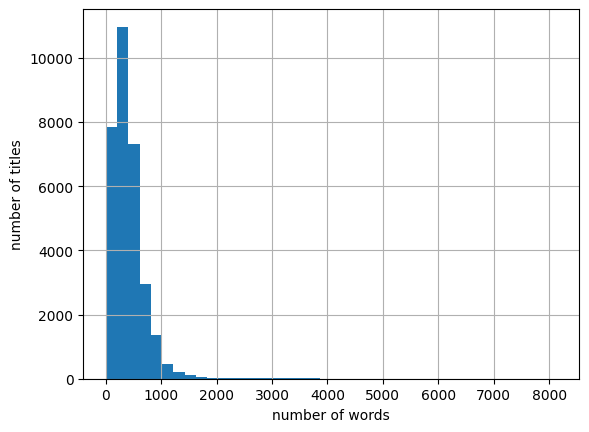

In [ ]:
seq_len = [len(title.split()) for title in train_text]
pd.Series(seq_len).hist(bins = 40)
plt.xlabel('number of words')
plt.ylabel('number of titles')
# plt.show()
# more than 100000 title have words between 500 and 700 for example

In [ ]:
sample_data = ['build fake news model.', 'using bert']
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data, padding = True)
print(tokenized_sample_data)

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 102, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 0, 0, 0]]}


In [ ]:
max_len = 15
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_len,
    padding=True,
    truncation=True,
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_len,
    padding=True,
    truncation=True,
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_len,
    padding=True,
    truncation=True,
)

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freezing layers
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class Bert_Arch(nn.Module):
    def __init__(self, bert):
        super(Bert_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim = 1)
    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask = mask)['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
model = Bert_Arch(bert)
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-5)
cross_entropy = nn.NLLLoss()
epochs = 2

In [ ]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  for step, batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('batch{:>5,} of {:>5,}'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
    optimizer.step()
    preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(train_dataloader)
  return avg_loss
def evaluate():
  print('\nEvaluating...')
  total_loss, total_accuracy = 0, 0
  for step, batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      print('batch{:>5,} of {:>5,}'.format(step, len(val_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds, labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)
  return avg_loss

In [ ]:
best_valid_loss = float('inf')
train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
  print('\nEpoch: {}/{}'.format(epoch + 1, epochs))
  train_loss = train()
  val_loss = evaluate()
  if val_loss < best_valid_loss:
    best_valid_loss = val_loss
    torch.save(model.state_dict(), 'saved_weights.pt')
  train_loss_list.append(train_loss)
  val_loss_list.append(val_loss)
  print('Training Loss: {:.3f}'.format(train_loss))
  print('Validation Loss: {:.3f}'.format(val_loss))


Epoch: 1/2


/tmp/ipython-input-2811191770.py:14: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)


batch   50 of   983
batch  100 of   983
batch  150 of   983
batch  200 of   983
batch  250 of   983
batch  300 of   983
batch  350 of   983
batch  400 of   983
batch  450 of   983
batch  500 of   983
batch  550 of   983
batch  600 of   983
batch  650 of   983
batch  700 of   983
batch  750 of   983
batch  800 of   983
batch  850 of   983
batch  900 of   983
batch  950 of   983

Evaluating...
batch   50 of   211
batch  100 of   211
batch  150 of   211
batch  200 of   211
Training Loss: 0.497
Validation Loss: 0.367

Epoch: 2/2
batch   50 of   983
batch  100 of   983
batch  150 of   983
batch  200 of   983
batch  250 of   983
batch  300 of   983
batch  350 of   983
batch  400 of   983
batch  450 of   983
batch  500 of   983
batch  550 of   983
batch  600 of   983
batch  650 of   983
batch  700 of   983
batch  750 of   983
batch  800 of   983
batch  850 of   983
batch  900 of   983
batch  950 of   983

Evaluating...
batch   50 of   211
batch  100 of   211
batch  150 of   211
batch  200 of 

In [ ]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3212
           1       0.94      0.95      0.95      3523

    accuracy                           0.95      6735
   macro avg       0.95      0.95      0.95      6735
weighted avg       0.95      0.95      0.95      6735



In [ ]:
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",        # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    padding=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 0, 1])

In [ ]:
from google.colab import files
files.download("/content/saved_weights.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>